In [ ]:
!pip install fiftyone
!pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
from torchvision import transforms as T
from fiftyone import ViewField as F
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

In [5]:
train_foz = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["segmentations"],
    classes=["cat"],
    max_samples=100,
)
val_foz = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    classes=["cat"],
    max_samples=10,
)

#session = fo.launch_app(dataset)

Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-10'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Here is the class allowing to process fiftyone data

In [6]:
import torch
import fiftyone.utils.coco as fouc
from PIL import Image

class FiftyOneTorchDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        area = []
        iscrowd = []
        detections = sample[self.gt_field].detections
        for det in detections:
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_detection(
                det, metadata, category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_obj.category_id)
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

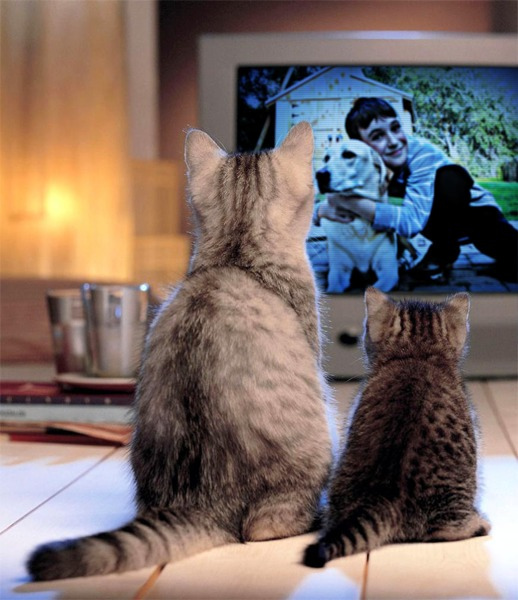

In [7]:
train = FiftyOneTorchDataset(train_foz)
val = FiftyOneTorchDataset(val_foz)
train[0][0]

Cloning some useful training functions

In [8]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

The COCO data does not involve masks however the only stable modifyable maskrcnn i found asserted the presence of mask data in the target so I decided to use fasterrcnn. I had dozens of RAM and memory overloads so I will only train on 100 images using 10 epochs and batchsize of 1. 

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
dataset = FiftyOneTorchDataset(train_foz, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

from torch.optim.lr_scheduler import StepLR
num_epochs = 10
losses, lc, lbr = [], [], []
for epoch in range(num_epochs):
    logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    losses.append(logger.loss.value)
    lc.append(logger.loss_classifier.value)
    lbr.append(logger.loss_box_reg.value)
    lr_scheduler.step()

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kerne

Epoch: [0]  [  0/100]  eta: 0:02:19  lr: 0.000055  loss: 1.2549 (1.2549)  loss_classifier: 1.0259 (1.0259)  loss_box_reg: 0.1852 (0.1852)  loss_objectness: 0.0034 (0.0034)  loss_rpn_box_reg: 0.0403 (0.0403)  time: 1.3936  data: 0.2365  max mem: 1369
Epoch: [0]  [ 10/100]  eta: 0:01:15  lr: 0.000560  loss: 1.1589 (1.4298)  loss_classifier: 0.9641 (1.1942)  loss_box_reg: 0.1738 (0.2047)  loss_objectness: 0.0043 (0.0061)  loss_rpn_box_reg: 0.0091 (0.0248)  time: 0.8433  data: 0.0272  max mem: 1663
Epoch: [0]  [ 20/100]  eta: 0:01:04  lr: 0.001065  loss: 1.6265 (1.7463)  loss_classifier: 1.0179 (1.3932)  loss_box_reg: 0.2686 (0.3113)  loss_objectness: 0.0097 (0.0120)  loss_rpn_box_reg: 0.0102 (0.0297)  time: 0.7782  data: 0.0063  max mem: 1663
Epoch: [0]  [ 30/100]  eta: 0:00:55  lr: 0.001569  loss: 1.2957 (1.5966)  loss_classifier: 0.9106 (1.2098)  loss_box_reg: 0.3995 (0.3353)  loss_objectness: 0.0174 (0.0167)  loss_rpn_box_reg: 0.0246 (0.0348)  time: 0.7747  data: 0.0079  max mem: 1663


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [1]  [  0/100]  eta: 0:02:02  lr: 0.005000  loss: 1.3386 (1.3386)  loss_classifier: 0.5991 (0.5991)  loss_box_reg: 0.3059 (0.3059)  loss_objectness: 0.3541 (0.3541)  loss_rpn_box_reg: 0.0795 (0.0795)  time: 1.2281  data: 0.3534  max mem: 1663
Epoch: [1]  [ 10/100]  eta: 0:01:14  lr: 0.005000  loss: 0.8418 (1.0952)  loss_classifier: 0.4005 (0.5418)  loss_box_reg: 0.3059 (0.3380)  loss_objectness: 0.0893 (0.1757)  loss_rpn_box_reg: 0.0274 (0.0396)  time: 0.8277  data: 0.0377  max mem: 1663
Epoch: [1]  [ 20/100]  eta: 0:01:03  lr: 0.005000  loss: 0.7556 (0.9790)  loss_classifier: 0.3648 (0.4904)  loss_box_reg: 0.2527 (0.3152)  loss_objectness: 0.0695 (0.1359)  loss_rpn_box_reg: 0.0244 (0.0375)  time: 0.7755  data: 0.0069  max mem: 1663
Epoch: [1]  [ 30/100]  eta: 0:00:55  lr: 0.005000  loss: 0.7768 (1.0005)  loss_classifier: 0.4033 (0.5153)  loss_box_reg: 0.2827 (0.3344)  loss_objectness: 0.0513 (0.1144)  loss_rpn_box_reg: 0.0283 (0.0365)  time: 0.7783  data: 0.0067  max mem: 1663


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [2]  [  0/100]  eta: 0:01:57  lr: 0.005000  loss: 0.4155 (0.4155)  loss_classifier: 0.1546 (0.1546)  loss_box_reg: 0.1707 (0.1707)  loss_objectness: 0.0077 (0.0077)  loss_rpn_box_reg: 0.0825 (0.0825)  time: 1.1751  data: 0.3841  max mem: 1663
Epoch: [2]  [ 10/100]  eta: 0:01:11  lr: 0.005000  loss: 0.7340 (0.8438)  loss_classifier: 0.3910 (0.4798)  loss_box_reg: 0.2314 (0.2770)  loss_objectness: 0.0310 (0.0337)  loss_rpn_box_reg: 0.0330 (0.0534)  time: 0.7978  data: 0.0407  max mem: 1663
Epoch: [2]  [ 20/100]  eta: 0:01:03  lr: 0.005000  loss: 0.7340 (0.8739)  loss_classifier: 0.3910 (0.5053)  loss_box_reg: 0.2314 (0.2777)  loss_objectness: 0.0340 (0.0387)  loss_rpn_box_reg: 0.0237 (0.0522)  time: 0.7804  data: 0.0065  max mem: 1663
Epoch: [2]  [ 30/100]  eta: 0:00:55  lr: 0.005000  loss: 0.6825 (0.8377)  loss_classifier: 0.3523 (0.4831)  loss_box_reg: 0.2024 (0.2760)  loss_objectness: 0.0257 (0.0354)  loss_rpn_box_reg: 0.0234 (0.0432)  time: 0.7877  data: 0.0066  max mem: 1663


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [3]  [  0/100]  eta: 0:01:46  lr: 0.000500  loss: 0.3464 (0.3464)  loss_classifier: 0.1548 (0.1548)  loss_box_reg: 0.1462 (0.1462)  loss_objectness: 0.0084 (0.0084)  loss_rpn_box_reg: 0.0370 (0.0370)  time: 1.0638  data: 0.2974  max mem: 1663
Epoch: [3]  [ 10/100]  eta: 0:01:14  lr: 0.000500  loss: 0.6813 (0.7158)  loss_classifier: 0.3692 (0.3697)  loss_box_reg: 0.2162 (0.2598)  loss_objectness: 0.0205 (0.0313)  loss_rpn_box_reg: 0.0370 (0.0549)  time: 0.8236  data: 0.0336  max mem: 1663
Epoch: [3]  [ 20/100]  eta: 0:01:04  lr: 0.000500  loss: 0.7481 (0.7699)  loss_classifier: 0.3692 (0.3911)  loss_box_reg: 0.2691 (0.2920)  loss_objectness: 0.0205 (0.0301)  loss_rpn_box_reg: 0.0204 (0.0567)  time: 0.7937  data: 0.0072  max mem: 1663
Epoch: [3]  [ 30/100]  eta: 0:00:55  lr: 0.000500  loss: 0.7232 (0.7433)  loss_classifier: 0.3753 (0.3909)  loss_box_reg: 0.2658 (0.2752)  loss_objectness: 0.0221 (0.0278)  loss_rpn_box_reg: 0.0198 (0.0493)  time: 0.7859  data: 0.0069  max mem: 1663


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [4]  [  0/100]  eta: 0:01:54  lr: 0.000500  loss: 0.3724 (0.3724)  loss_classifier: 0.1505 (0.1505)  loss_box_reg: 0.1621 (0.1621)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0552 (0.0552)  time: 1.1411  data: 0.3659  max mem: 1663
Epoch: [4]  [ 10/100]  eta: 0:01:12  lr: 0.000500  loss: 0.2420 (0.3463)  loss_classifier: 0.1315 (0.1714)  loss_box_reg: 0.1078 (0.1395)  loss_objectness: 0.0089 (0.0095)  loss_rpn_box_reg: 0.0103 (0.0259)  time: 0.8111  data: 0.0382  max mem: 1663
Epoch: [4]  [ 20/100]  eta: 0:01:05  lr: 0.000500  loss: 0.3157 (0.4237)  loss_classifier: 0.1321 (0.2064)  loss_box_reg: 0.1528 (0.1743)  loss_objectness: 0.0110 (0.0125)  loss_rpn_box_reg: 0.0130 (0.0305)  time: 0.7978  data: 0.0060  max mem: 1663
Epoch: [4]  [ 30/100]  eta: 0:00:57  lr: 0.000500  loss: 0.5980 (0.4836)  loss_classifier: 0.2534 (0.2342)  loss_box_reg: 0.2059 (0.2021)  loss_objectness: 0.0172 (0.0148)  loss_rpn_box_reg: 0.0146 (0.0326)  time: 0.8301  data: 0.0069  max mem: 1663


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [5]  [  0/100]  eta: 0:01:54  lr: 0.000500  loss: 1.1779 (1.1779)  loss_classifier: 0.7762 (0.7762)  loss_box_reg: 0.3827 (0.3827)  loss_objectness: 0.0079 (0.0079)  loss_rpn_box_reg: 0.0111 (0.0111)  time: 1.1482  data: 0.3868  max mem: 1663
Epoch: [5]  [ 10/100]  eta: 0:01:15  lr: 0.000500  loss: 0.3453 (0.5183)  loss_classifier: 0.1938 (0.2728)  loss_box_reg: 0.1788 (0.2180)  loss_objectness: 0.0090 (0.0106)  loss_rpn_box_reg: 0.0111 (0.0168)  time: 0.8341  data: 0.0403  max mem: 1663
Epoch: [5]  [ 20/100]  eta: 0:01:05  lr: 0.000500  loss: 0.3255 (0.4386)  loss_classifier: 0.1871 (0.2251)  loss_box_reg: 0.1477 (0.1877)  loss_objectness: 0.0072 (0.0114)  loss_rpn_box_reg: 0.0101 (0.0144)  time: 0.8076  data: 0.0062  max mem: 1663
Epoch: [5]  [ 30/100]  eta: 0:00:56  lr: 0.000500  loss: 0.3407 (0.4984)  loss_classifier: 0.2026 (0.2522)  loss_box_reg: 0.1477 (0.2102)  loss_objectness: 0.0103 (0.0131)  loss_rpn_box_reg: 0.0081 (0.0230)  time: 0.7911  data: 0.0071  max mem: 1663


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [6]  [  0/100]  eta: 0:01:54  lr: 0.000050  loss: 0.2509 (0.2509)  loss_classifier: 0.0756 (0.0756)  loss_box_reg: 0.0661 (0.0661)  loss_objectness: 0.0041 (0.0041)  loss_rpn_box_reg: 0.1050 (0.1050)  time: 1.1413  data: 0.2930  max mem: 1663
Epoch: [6]  [ 10/100]  eta: 0:01:13  lr: 0.000050  loss: 0.2900 (0.4015)  loss_classifier: 0.1216 (0.2053)  loss_box_reg: 0.1446 (0.1594)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0229 (0.0321)  time: 0.8216  data: 0.0330  max mem: 1663
Epoch: [6]  [ 20/100]  eta: 0:01:05  lr: 0.000050  loss: 0.3708 (0.4334)  loss_classifier: 0.1626 (0.2091)  loss_box_reg: 0.1446 (0.1766)  loss_objectness: 0.0060 (0.0088)  loss_rpn_box_reg: 0.0229 (0.0388)  time: 0.8019  data: 0.0072  max mem: 1663
Epoch: [6]  [ 30/100]  eta: 0:00:57  lr: 0.000050  loss: 0.3708 (0.4323)  loss_classifier: 0.1633 (0.2077)  loss_box_reg: 0.1419 (0.1764)  loss_objectness: 0.0088 (0.0106)  loss_rpn_box_reg: 0.0143 (0.0376)  time: 0.8115  data: 0.0072  max mem: 1663


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [7]  [  0/100]  eta: 0:01:47  lr: 0.000050  loss: 0.5806 (0.5806)  loss_classifier: 0.2524 (0.2524)  loss_box_reg: 0.2899 (0.2899)  loss_objectness: 0.0191 (0.0191)  loss_rpn_box_reg: 0.0191 (0.0191)  time: 1.0716  data: 0.2773  max mem: 1663
Epoch: [7]  [ 10/100]  eta: 0:01:12  lr: 0.000050  loss: 0.2421 (0.3703)  loss_classifier: 0.1235 (0.1799)  loss_box_reg: 0.1032 (0.1570)  loss_objectness: 0.0038 (0.0118)  loss_rpn_box_reg: 0.0111 (0.0216)  time: 0.8096  data: 0.0311  max mem: 1663
Epoch: [7]  [ 20/100]  eta: 0:01:03  lr: 0.000050  loss: 0.2633 (0.4278)  loss_classifier: 0.1235 (0.2167)  loss_box_reg: 0.1090 (0.1747)  loss_objectness: 0.0060 (0.0105)  loss_rpn_box_reg: 0.0140 (0.0260)  time: 0.7768  data: 0.0064  max mem: 1663
Epoch: [7]  [ 30/100]  eta: 0:00:55  lr: 0.000050  loss: 0.2775 (0.3856)  loss_classifier: 0.1310 (0.1890)  loss_box_reg: 0.1322 (0.1658)  loss_objectness: 0.0067 (0.0102)  loss_rpn_box_reg: 0.0116 (0.0206)  time: 0.7902  data: 0.0064  max mem: 1663


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [8]  [  0/100]  eta: 0:01:58  lr: 0.000050  loss: 0.4007 (0.4007)  loss_classifier: 0.1699 (0.1699)  loss_box_reg: 0.2042 (0.2042)  loss_objectness: 0.0185 (0.0185)  loss_rpn_box_reg: 0.0082 (0.0082)  time: 1.1856  data: 0.3583  max mem: 1663
Epoch: [8]  [ 10/100]  eta: 0:01:13  lr: 0.000050  loss: 0.3506 (0.4110)  loss_classifier: 0.1636 (0.2038)  loss_box_reg: 0.1630 (0.1806)  loss_objectness: 0.0079 (0.0095)  loss_rpn_box_reg: 0.0082 (0.0172)  time: 0.8162  data: 0.0384  max mem: 1663
Epoch: [8]  [ 20/100]  eta: 0:01:04  lr: 0.000050  loss: 0.3311 (0.4545)  loss_classifier: 0.1541 (0.2156)  loss_box_reg: 0.1456 (0.1893)  loss_objectness: 0.0079 (0.0116)  loss_rpn_box_reg: 0.0105 (0.0379)  time: 0.7908  data: 0.0068  max mem: 1663
Epoch: [8]  [ 30/100]  eta: 0:00:56  lr: 0.000050  loss: 0.3660 (0.4805)  loss_classifier: 0.2183 (0.2420)  loss_box_reg: 0.1472 (0.1900)  loss_objectness: 0.0109 (0.0118)  loss_rpn_box_reg: 0.0133 (0.0367)  time: 0.8037  data: 0.0072  max mem: 1663


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [9]  [  0/100]  eta: 0:01:53  lr: 0.000005  loss: 0.2778 (0.2778)  loss_classifier: 0.0800 (0.0800)  loss_box_reg: 0.0834 (0.0834)  loss_objectness: 0.0106 (0.0106)  loss_rpn_box_reg: 0.1038 (0.1038)  time: 1.1352  data: 0.2806  max mem: 1663
Epoch: [9]  [ 10/100]  eta: 0:01:16  lr: 0.000005  loss: 0.4812 (0.5791)  loss_classifier: 0.2322 (0.3079)  loss_box_reg: 0.2263 (0.2192)  loss_objectness: 0.0109 (0.0159)  loss_rpn_box_reg: 0.0189 (0.0362)  time: 0.8450  data: 0.0307  max mem: 1663
Epoch: [9]  [ 20/100]  eta: 0:01:05  lr: 0.000005  loss: 0.3738 (0.4355)  loss_classifier: 0.1769 (0.2272)  loss_box_reg: 0.1313 (0.1730)  loss_objectness: 0.0069 (0.0107)  loss_rpn_box_reg: 0.0130 (0.0246)  time: 0.7985  data: 0.0061  max mem: 1663
Epoch: [9]  [ 30/100]  eta: 0:00:56  lr: 0.000005  loss: 0.3758 (0.4715)  loss_classifier: 0.1567 (0.2316)  loss_box_reg: 0.1262 (0.1976)  loss_objectness: 0.0058 (0.0115)  loss_rpn_box_reg: 0.0111 (0.0308)  time: 0.7832  data: 0.0065  max mem: 1663


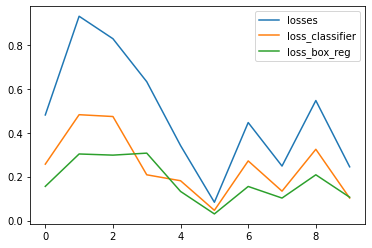

In [11]:
import pandas as pd
df = pd.DataFrame()
df["losses"] = losses
df["loss_classifier"] = lc
df["loss_box_reg"] = lbr
df = df.reset_index()
df.columns = ["epoch","losses","loss_classifier","loss_box_reg"]
df.drop("epoch",1).plot()

In [12]:
val_dataset = FiftyOneTorchDataset(val_foz, get_transform(train=False))
model.to(torch.device('cpu'))
model.eval()
pred = model([val_dataset[i][0] for i in range(1)])

The finetuned model got trained on 100 images containing cats and dogs and managed to recognize the dog in the test image which is good enough. I used only the most confident box and label.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


['dog']


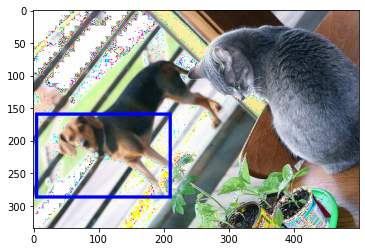

In [102]:
coco_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
from torchvision.utils import draw_bounding_boxes
i = 0
original_image = val_dataset[i][0]
image_int = plt.imshow(original_image.permute(1,2,0))
tensor_image = torch.tensor(val_dataset[i][0]*256).to(torch.uint8)
plt.savefig("original_image"+str(i))
boxes = torch.tensor(pred[i]["boxes"][0:1], dtype=torch.float)
labels = pred[i]["labels"][0:1]
scores = pred[i]["scores"][0:1]

#boxes = torch.tensor([[50, 50, 100, 200], [210, 150, 350, 430]], dtype=torch.float)
colors = ["blue", "yellow","red"]
result = draw_bounding_boxes(tensor_image, boxes, colors=colors, width=5)
plt.imshow(result.permute(1, 2, 0))
plt.show()
plt.savefig("image"+str(i)+".png")
print([coco_classes[i] for i in list(labels.numpy())])

# **Adding Feature Noise**

I managed to change the backbone without any modifications and make it work. 

Then I created a class to multiply the last tensor of the backbone by a random number between 0.8-1.2 on the training step only but never managed to make it work and left as a further study to stick to 4 hours. I would expect the losses to decrease as this works as a good regularization technique. I will leave the code as a pseudo-ish code for demonstration.

In [86]:
import torch.nn as nn

class Add_Noise(nn.Module):
  def __init__(self):
    super(Add_Noise, self).__init__()

  def forward(self, tensors):
    r1, r2 = 0.8, 1.2
    tensors = tensors.to(device='cuda')
    random_tensor = (r2 - r1) * torch.rand(tensors.size()) + r1
    random_tensor = random_tensor.to(device='cuda')
    result = tensors*random_tensor  
    return result

add_noise = Add_Noise()

In [97]:
x = torch.tensor([[1, 1, 1],[1,1,1]])
#x.requires_grad = True
add_noise(x)

tensor([[1.1939, 1.1497, 0.9190],
        [0.8357, 1.1125, 1.1895]], device='cuda:0')

In [95]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN

def fasterrcnn_resnet50_fpn(pretrained=False, progress=True,
                            num_classes=91, pretrained_backbone=True, **kwargs):
    if pretrained:
        pretrained_backbone = False
    backbone = torchvision.models.resnet18(pretrained=True)
    for param in backbone.parameters():
      param.requires_grad = False

    num_features = backbone.fc.in_features
    backbone = torch.nn.Sequential(*list(backbone.children())[:-1])
    backbone.out_channels = 1280
    backbone.fc = nn.Sequential(
      add_noise,
      nn.Linear(num_features, 91)
  )

    model = FasterRCNN(backbone, num_classes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['fasterrcnn_resnet50_fpn_coco'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

model = fasterrcnn_resnet50_fpn()


In [ ]:
model.to(torch.device('cuda'))
num_epochs = 1
losses, lc, lbr = [], [], []
for epoch in range(num_epochs):
    logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    losses.append(logger.loss.value)
    lc.append(logger.loss_classifier.value)
    lbr.append(logger.loss_box_reg.value)
    lr_scheduler.step()